In [ ]:
!nvidia=smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Set some constants for further use
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50


In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data Science project/Potato Diesease/training/PlantVillage",seed=123,shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2150 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 0 1 2 1 1 1 0 1 1 1 1 0 0 0 0 1 2 0 1 0 1 0 1 1 1 0 1]


Above each element in dataset is tuple.first element is a batch of 32 element of images.second element is batch of 32 element of class labels.

### **Image Visualization from Dataset**

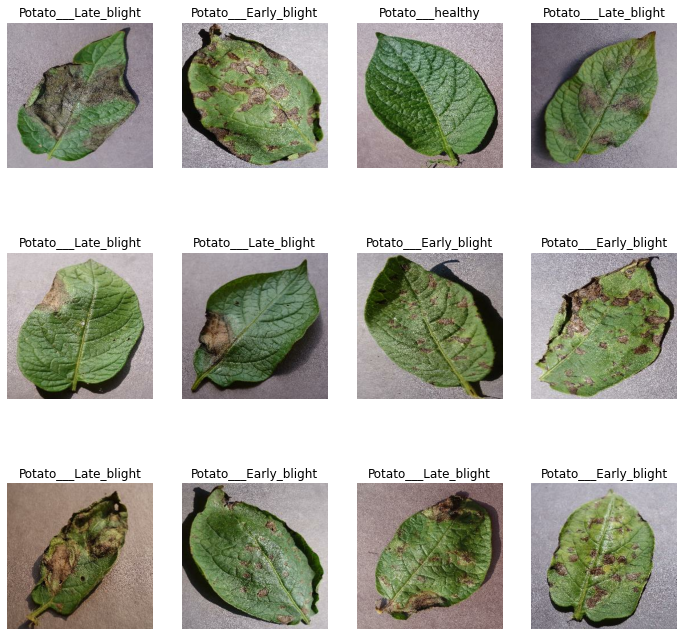

In [ ]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')



##Split Dataset into 
####Train-Dataset used while training
####Validation-Dataset tested against while training
####Test-Dataset to be tasted against after trained model


In [ ]:
#here in tesnorflow we can't directly use train_test_split as sklearn.
#here we split data with the help of .take and .skip function

In [ ]:
def dataset_split(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
            
            ds_size=len(ds)

            if shuffle:
              ds=ds.shuffle(shuffle_size,seed=12)
            
            train_size=int(ds_size*train_split)
            val_size=int(ds_size*val_split)

            train_ds=ds.take(train_size)
            val_ds=ds.skip(train_size).take(val_size)
            test_ds=ds.skip(train_size).skip(val_size)

            return train_ds,val_ds,test_ds
    

In [ ]:
train_ds,val_ds,test_ds = dataset_split(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

**Cache,Shuffle and Prefetch the dataset**

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#Building Model
###Creating a layer for Resizing and Normalization

In [ ]:
resize_rescale=tf.keras.Sequential([
      layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
      layers.experimental.preprocessing.Rescaling(1./255),
])

#Data Augmentation
this is needed when we have limited data and used to increase elements  of data by using diffrent proccess like rotating,contrast,cropping etc and also boost accuracy of model.

In [ ]:
data_augmentation=tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      layers.experimental.preprocessing.RandomRotation(0.2)
])

###Applying Data Augmentation to train dataset

In [ ]:
train_ds=train_ds.map(
    lambda x,y: (data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

#Model Architecture
#####we use CNN with softmax activation in o/p layer.we also add the initial layers for resizing ,normalization and Data Augmentaion

In [ ]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
      resize_rescale,
      layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Flatten(),
      layers.Dense(64,activation='relu'),
      layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

#Compilling the model
#####we use adam optimizer and sparsCategoricalCrossentropy for losses and accuracy as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50
54/54 [==============================] - 503s 4s/step - loss: 0.9050 - accuracy: 0.5023 - val_loss: 0.8349 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - 186s 3s/step - loss: 0.6692 - accuracy: 0.7020 - val_loss: 0.5947 - val_accuracy: 0.7292
Epoch 3/50
54/54 [==============================] - 184s 3s/step - loss: 0.4289 - accuracy: 0.8056 - val_loss: 0.4097 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 185s 3s/step - loss: 0.3090 - accuracy: 0.8744 - val_loss: 0.3028 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 189s 4s/step - loss: 0.3729 - accuracy: 0.8519 - val_loss: 0.3737 - val_accuracy: 0.8385
Epoch 6/50
54/54 [==============================] - 186s 3s/step - loss: 0.2724 - accuracy: 0.8981 - val_loss: 0.3989 - val_accuracy: 0.8490
Epoch 7/50
54/54 [==============================] - 185s 3s/step - loss: 0.2095 - accuracy: 0.9236 - val_loss: 0.3190 - val_accuracy: 0.8802
Epoch 8/50
54

In [ ]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 6s 61ms/step - loss: 0.0026 - accuracy: 1.0000


In [ ]:
#here we getting 100% accuracy.this is considered as best we get

In [ ]:
scores

[0.0026085202116519213, 1.0]

In [ ]:
#scores is just list of containing losses and accuracy

#Plotting the Accuracy and Loss Curves

In [36]:
history

In [37]:
history.params

{'epochs': 50, 'steps': 54, 'verbose': 1}

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
type(history.history['loss'])

list

In [41]:
len(history.history['loss'])

50

In [42]:
history.history['loss'][:5]

[0.8968479633331299,
 0.6589100956916809,
 0.5454021096229553,
 0.3565824627876282,
 0.28885090351104736]

In [45]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

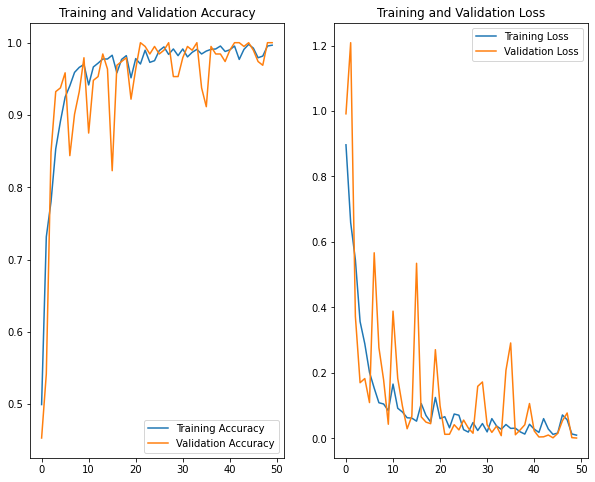

In [49]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#Run Prediction on a sample Image

first image to predict
actual label:  Potato___Late_blight
predicted label :  Potato___Late_blight


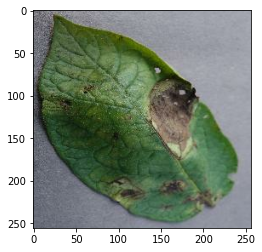

In [85]:
import numpy as np

for image_batch,label_batch in test_ds.take(1):

  first_image = image_batch[0].numpy().astype("uint8")
  first_label = label_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label: ',class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print('predicted label : ',class_names[np.argmax(batch_prediction[0])])

In [97]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class= class_names[np.argmax(predictions[0])]
  confidence= round(100 * (np.max(predictions[0])),2)
  return predicted_class ,confidence

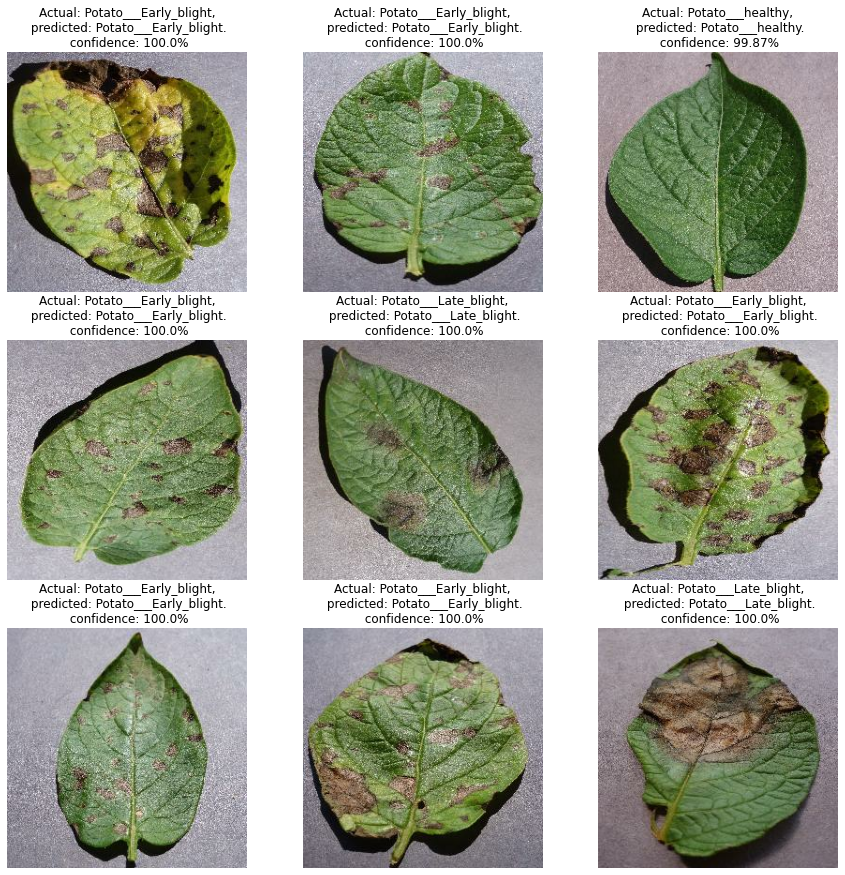

In [98]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in  range(9):
        ax = plt.subplot(3,3,i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n predicted: {predicted_class}.\n confidence: {confidence}%")

        plt.axis('off')

#Save Model

In [135]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


In [139]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]]) +1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2/assets


#Saving The Model
#####we append the model to the list of model as new version

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

FileNotFoundError: ignored